In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Import function to generate toy classication problem
from sklearn.datasets import make_moons
import numpy as np

# Import library for plots
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tfe.enable_eager_execution()


In [3]:
X, y = make_moons(n_samples=100, noise=0.1, random_state=2018)


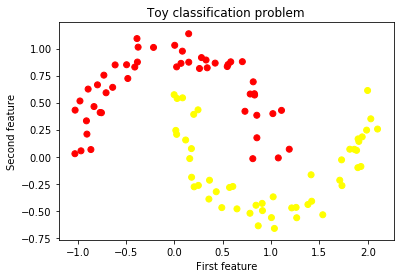

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.autumn)
plt.xlabel('First feature')
plt.ylabel('Second feature')
plt.title('Toy classification problem')
plt.show()

In [5]:
X.shape

(100, 2)

In [6]:
tf.nn.relu

<function tensorflow.python.ops.gen_nn_ops.relu>

In [7]:
class simple_nn(tf.keras.Model):
    def __init__(self):
        super(simple_nn, self).__init__()
        
        self.dense_layer = tf.layers.Dense(10, activation=tf.nn.relu)
        self.output_layer = tf.layers.Dense(2, activation=None)
        
    def predict(self, input_data):
        hidden_activations = self.dense_layer(input_data)
        logits = self.output_layer(hidden_activations)
        return logits
    
    def loss_fn(self, input_data, target):
        logits = self.predict(input_data)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=target, logits=logits)
        return loss
    
    def grads_fn(self, input_data, target):
        
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(input_data, target)
        return tape.gradient(loss, self.variables)
    
    def fit(self, input_data, target, optimizer, num_epochs=500, verbose=50):
        for i in range(num_epochs):
            grads = self.grads_fn(input_data, target)
            optimizer.apply_gradients(zip(grads, self.variables))
            if(i==0) | (i+1) % verbose ==0 :
                print('Loss at epoch %d: %f' % (i+1, self.loss_fn(input_data, target).numpy()))

In [8]:
X_tensor = tf.constant(X)
y_tensor = tf.constant(y)

In [9]:
optimizer = tf.train.GradientDescentOptimizer(5e-1)
model = simple_nn()
model.fit(X_tensor, y_tensor, optimizer, num_epochs=500, verbose=50)

Loss at epoch 50: 0.264180
Loss at epoch 100: 0.235051
Loss at epoch 150: 0.204706
Loss at epoch 200: 0.163545
Loss at epoch 250: 0.125111
Loss at epoch 300: 0.096802
Loss at epoch 350: 0.075933
Loss at epoch 400: 0.060664
Loss at epoch 450: 0.050250
Loss at epoch 500: 0.042631


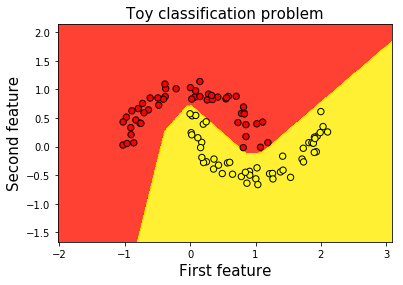

In [10]:
# Create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict target for each sample xx, yy
Z = np.argmax(model.predict(tf.constant(np.c_[xx.ravel(), yy.ravel()])).numpy(), axis=1)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.autumn, alpha=0.8)

# Plot our training points
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.autumn, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('First feature', fontsize=15)
plt.ylabel('Second feature', fontsize=15)
plt.title('Toy classification problem', fontsize=15)
plt.show()

In [11]:
from sklearn.datasets import load_wine
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA


In [12]:
wine_data = load_wine()


In [13]:
print('Type of data in the wine_data dictionary: ', list(wine_data.keys()))


('Type of data in the wine_data dictionary: ', ['target_names', 'data', 'target', 'DESCR', 'feature_names'])


In [14]:
print('Number of classes: ', len(np.unique(wine_data.target)))


('Number of classes: ', 3)


In [15]:
print('Distribution of our targets: ', np.unique(wine_data.target, return_counts=True)[1])

('Distribution of our targets: ', array([59, 71, 48]))


In [16]:
print('Number of features in the dataset: ', wine_data.data.shape[1])

('Number of features in the dataset: ', 13)


In [17]:
wine_data.data = (wine_data.data - np.mean(wine_data.data, axis=0))/np.std(wine_data.data, axis=0)

In [18]:
print('Standard deviation of each feature after standardization: ', np.std(wine_data.data, axis=0))

('Standard deviation of each feature after standardization: ', array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))


In [19]:
X_pca = PCA(n_components=2, random_state=2018).fit_transform(wine_data.data)

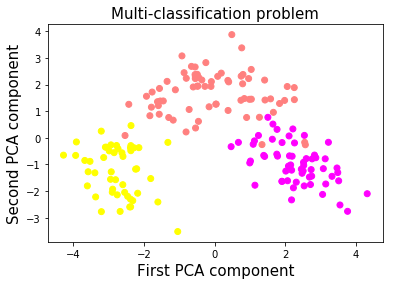

In [20]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=wine_data.target, cmap=plt.cm.spring)
plt.xlabel('First PCA component', fontsize=15)
plt.ylabel('Second PCA component', fontsize=15)
plt.title('Multi-classification problem', fontsize=15)
plt.show()

In [21]:
class two_layer_nn(tf.keras.Model):
    def __init__(self, output_size=2, loss_type='cross-entropy'):
        super(two_layer_nn, self).__init__()
        
        self.dense_1 = tf.layers.Dense(20, activation=tf.nn.relu)
        self.dense_2 = tf.layers.Dense(10, activation=tf.nn.relu)
        self.dense_out = tf.layers.Dense(output_size, activation=None)
        self.loss_type = loss_type
        
    def predict(self, input_data):
        layer_1 = self.dense_1(input_data)
        layer_2 = self.dense_2(layer_1)
        logits = self.dense_out(layer_2)
        return logits
    
    def loss_fn(self, input_data, target):
        preds = self.predict(input_data)
        if self.loss_type=='cross-entropy':
            loss = tf.losses.sparse_softmax_cross_entropy(labels=target, logits=preds)
            
        else:
            loss = tf.losses.mean_squared_error(target, preds)
        return loss
    def grads_fn(self, input_data, target):
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(input_data, target)
        return tape.gradient(loss, self.variables)
    
    def fit(self, input_data, target, optimizer, num_epochs=500, verbose=50, track_accuracy=True):
        if track_accuracy:
            self.hist_accuracy = []
            accuracy = tfe.metrics.Accuracy()
        
        for i in range(num_epochs):
            grads = self.grads_fn(input_data, target)
            optimizer.apply_gradients(zip(grads, self.variables))
            if track_accuracy:
                logits = self.predict(X)
                preds = tf.argmax(logits, axis=1)
                accuracy(preds, target)
                self.hist_accuracy.append(accuracy.result())
                accuracy.init_variables()
        
        

In [22]:
# Create input features and targets dataset. Transfer data from numpy to tensors.
X = tf.constant(wine_data.data)
y = tf.constant(wine_data.target)

In [23]:
# Define optimizer
optimizer = tf.train.GradientDescentOptimizer(5e-1)

# Initialize model 
model = two_layer_nn(output_size=3)

# Select here the number of epochs
num_epochs=50

# Train the model with gradient descent
model.fit(X, y, optimizer, num_epochs=num_epochs)

In [24]:
model.hist_accuracy

[<tf.Tensor: id=43651, shape=(), dtype=float64, numpy=0.7808988764044944>,
 <tf.Tensor: id=43772, shape=(), dtype=float64, numpy=0.9325842696629213>,
 <tf.Tensor: id=43893, shape=(), dtype=float64, numpy=0.949438202247191>,
 <tf.Tensor: id=44014, shape=(), dtype=float64, numpy=0.9662921348314607>,
 <tf.Tensor: id=44135, shape=(), dtype=float64, numpy=0.9719101123595506>,
 <tf.Tensor: id=44256, shape=(), dtype=float64, numpy=0.9719101123595506>,
 <tf.Tensor: id=44377, shape=(), dtype=float64, numpy=0.9775280898876404>,
 <tf.Tensor: id=44498, shape=(), dtype=float64, numpy=0.9831460674157303>,
 <tf.Tensor: id=44619, shape=(), dtype=float64, numpy=0.9831460674157303>,
 <tf.Tensor: id=44740, shape=(), dtype=float64, numpy=0.9831460674157303>,
 <tf.Tensor: id=44861, shape=(), dtype=float64, numpy=0.9887640449438202>,
 <tf.Tensor: id=44982, shape=(), dtype=float64, numpy=0.9943820224719101>,
 <tf.Tensor: id=45103, shape=(), dtype=float64, numpy=0.9943820224719101>,
 <tf.Tensor: id=45224, sha

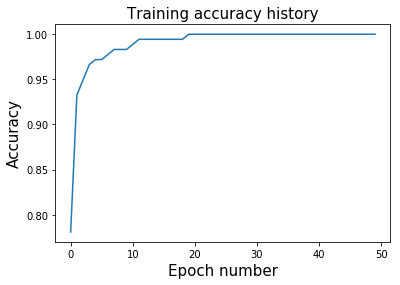

In [25]:
plt.plot(range(num_epochs), model.hist_accuracy);
plt.xlabel('Epoch number', fontsize=15);
plt.ylabel('Accuracy', fontsize=15);
plt.title('Training accuracy history', fontsize=15);

In [26]:
# Get the predictions on the entire dataset
logits = model.predict(X)
preds = tf.argmax(logits, axis=1)

In [27]:
# Print confusion matrix
conf_matrix = tf.confusion_matrix(y, preds, num_classes=3)
print('Confusion matrix:')
print( conf_matrix.numpy())

Confusion matrix:
[[59  0  0]
 [ 0 71  0]
 [ 0  0 48]]


In [28]:
def precision(labels, predictions, weights=None):
    conf_matrix = tf.confusion_matrix(labels, predictions, num_classes=3)
    tp_and_fp = tf.reduce_sum(conf_matrix, axis=0)
    tp = tf.diag_part(conf_matrix)
    precision_scores = tp/(tp_and_fp)
    if weights:
        precision_score = tf.multiply(precision_scores, weights)/tf.reduce_sum(weights)
    else:
        precision_score = tf.reduce_mean(precision_scores)        
    return precision_score

In [29]:
precision_score = precision(y, preds, weights=None)
print('Average precision: ', precision_score.numpy())

('Average precision: ', 1)


In [30]:
import pandas as pd

In [31]:
# Read input data. Assuming you've unzipped the dataset and put it into a folder named 'data'
path_data = 'datasets/fer2013/fer2013.csv'
data = pd.read_csv(path_data)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
emotion    35887 non-null int64
pixels     35887 non-null object
Usage      35887 non-null object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [33]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [34]:
emotion_cat = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}


In [35]:
target_counts = data['emotion'].value_counts().reset_index(drop=False)

In [36]:
target_counts.columns = ['emotion', 'sample_num']

In [37]:
target_counts['emotion'] = target_counts['emotion'].map(emotion_cat)

In [38]:
target_counts

,emotion,sample_num
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Disgust,547


In [39]:
data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

In [40]:
data.head()

,emotion,pixels,Usage
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Training
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Training
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",Training
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",Training
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",Training


In [41]:
random_seed = 2
data_sample = data.sample(10, random_state=random_seed)

In [42]:
from math import sqrt

sqrt(len(data_sample['pixels'].iloc[0]))

48.0

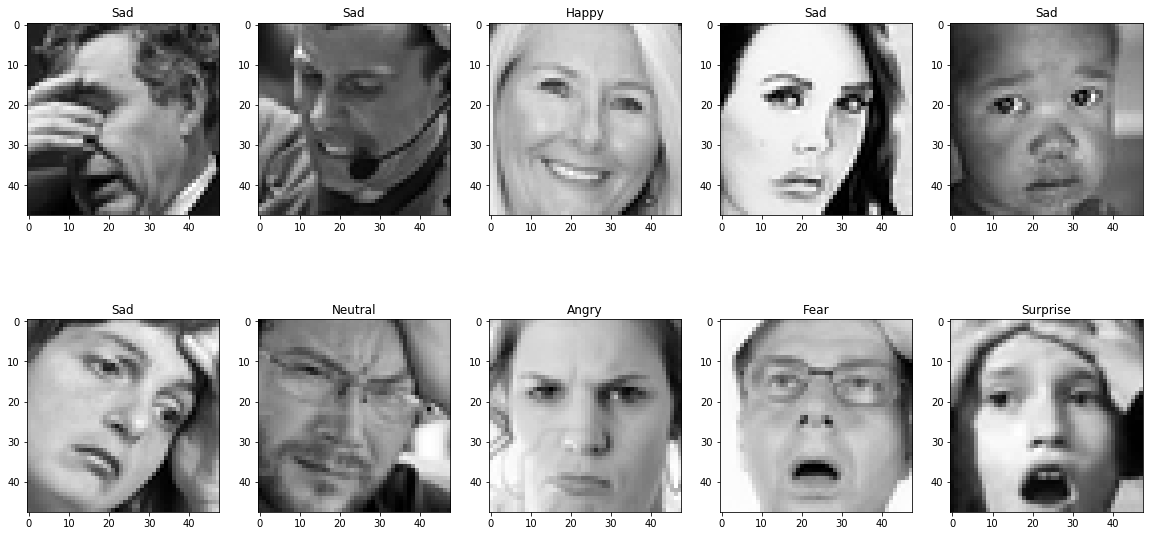

In [43]:
f,axes = plt.subplots(2, 5, figsize = (20, 10))
i, j = 0, 0
for idx, row in data_sample.iterrows():
    img = np.array(row['pixels']).reshape(48, 48)
    axes[i, j].imshow(img, cmap='gray')
    axes[i, j].set_title(emotion_cat[row['emotion']])
    
    if j==4:
        i += 1
        j = 0
    else:
        j += 1

In [44]:
data_train = data[data['Usage']=='Training']

In [45]:
size_train = data_train.shape[0]
size_train

28709

In [46]:
data_dev = data[data['Usage']!='Training']
size_dev = data_dev.shape[0]
size_dev

7178

In [47]:
# Retrieve train input and target
X_train, y_train = data_train['pixels'].tolist(), data_train['emotion'].as_matrix()
# Reshape images to 4D (num_samples, width, height, num_channels)
X_train = np.array(X_train, dtype='float32').reshape(-1,48,48,1)
# Normalize images with max (the maximum pixel intensity is 255)
X_train = X_train/255.0

# Retrieve dev input and target
X_dev, y_dev = data_dev['pixels'].tolist(), data_dev['emotion'].as_matrix()
# Reshape images to 4D (num_samples, width, height, num_channels)
X_dev = np.array(X_dev, dtype='float32').reshape(-1,48,48,1)
# Normalize images with max
X_dev = X_dev/255.0

In [48]:
y_train.shape

(28709,)

In [49]:
y_train[:, None].shape

(28709, 1)

In [50]:
batch_size = 64
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train[:, None])).batch(batch_size)

In [51]:
training_data

<BatchDataset shapes: ((?, 48, 48, 1), (?, 1)), types: (tf.float32, tf.int64)>

In [52]:
eval_data = tf.data.Dataset.from_tensor_slices((X_dev, y_dev[:,None])).batch(batch_size)


In [60]:
class EmotionRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        
        super(EmotionRecognitionCNN, self).__init__()
        
        self.conv1 = tf.layers.Conv2D(16 ,5, padding='same', activation=None)
        self.batch1 = tf.layers.BatchNormalization()
        self.conv2 = tf.layers.Conv2D(16, 5, 2, padding='same', activation=None)
        self.batch2= tf.layers.BatchNormalization()
        self.conv3 = tf.layers.Conv2D(32, 5, padding='same', activation=None)
        self.batch3 = tf.layers.BatchNormalization()
        self.conv4 = tf.layers.Conv2D(32, 5, 2, padding = 'same', activation = None)
        self.batch4 = tf.layers.BatchNormalization()
        self.conv5 = tf.layers.Conv2D(64, 3, padding='same', activation=None)
        self.batch5 = tf.layers.BatchNormalization()
        self.conv6 = tf.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        self.batch6 = tf.layers.BatchNormalization()
        self.conv7 = tf.layers.Conv2D(64, 1, padding='same', activation=None)
        self.batch7 = tf.layers.BatchNormalization()
        self.conv8 = tf.layers.Conv2D(128, 3, 2, padding='same', activation=None)
        self.batch8 = tf.keras.layers.BatchNormalization()
        self.conv9 = tf.layers.Conv2D(256, 1, padding='same', activation=None)
        self.batch9 = tf.keras.layers.BatchNormalization()
        self.conv10 = tf.layers.Conv2D(128, 3, 2, padding='same', activation=None)
        self.conv11 = tf.layers.Conv2D(256, 1, padding='same', activation=None)
        self.batch11 = tf.layers.BatchNormalization()
        self.conv12 = tf.layers.Conv2D(num_classes, 3, 2, padding='same', activation=None)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, images, training):
        
        x = self.conv1(images)
        x = self.batch1(x, training=training)
        x = self.conv2(x)
        x = self.batch2(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.4, training=training)
        x = self.conv3(x)
        x = self.batch3(x, training=training)
        x = self.conv4(x)
        x = self.batch4(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.3, training=training)
        x = self.conv5(x)
        x = self.batch5(x, training=training)
        x = self.conv6(x)
        x = self.batch6(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.3, training=training)
        x = self.conv7(x)
        x = self.batch7(x, training=training)
        x = self.conv8(x)
        x = self.batch8(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.3, training=training)
        x = self.conv9(x)
        x = self.batch9(x, training=training)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.batch11(x, training=training)
        x = self.conv12(x)
        return tf.layers.flatten(x)
    
    
    def loss_fn(self, images, target, training):
        preds = self.predict(images, training)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=target, logits=preds)
        return loss
    
    def grads_fn(self, images, target, training):
        
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        with tf.device(self.device):
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            
            saver = tfe.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint(self.checkpoint_directory))
            
    
    def save_model(self, global_step=0):
        tfe.Saver(self.variables).save(self.checkpoint_directory,
                                      global_step=global_step)
        
    def compute_accuracy(self, input_data):
        with tf.device(self.device):
            acc = tfe.metrics.Accuracy()
            for images, targets in tfe.Iterator(input_data):
                logits = self.predict(images, training=False)
                preds = tf.argmax(logits, axis=1)
                acc(tf.reshape(targets, [-1,]), preds)
        return acc
    
    def fit(self, training_data, eval_data, optimizer, num_epochs=500,
           early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        
        if train_from_scratch == False:
            self.restore_model()
            
        best_loss = 999
        train_loss = tfe.metrics.Mean('train_loss')
        eval_loss = tfe.metrics.Mean('eval_loss')
        
        self.history={}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []

        with tf.device(self.device):
            for i in range(num_epochs):
                print i
                for images, target in tfe.Iterator(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                for images, target in tfe.Iterator(training_data):
                    loss = self.loss_fn(images, target, False)
                    train_loss(loss)

                self.history['train_loss'].append(train_loss.result().numpy())
                train_loss.init_variables()
                
                for images, target in tfe.Iterator(eval_data):
                    loss = self.loss_fn(images, target, False)
                    eval_loss(loss)
                
                self.history['eval_loss'].append(eval_loss.result().numpy())
                
                eval_loss.init_variables()
                
                if(i==0 | (i+1) % verbose ==0):
                    print('Train loss at epoch %d: ' % (i+1), self.history['train_loss'][-1])
                    print('Eval loss at epoch  %d: ' % (i+1), self.history['eval_loss'][-1])
                    
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -=1
                
                if count ==0:
                    break

    

In [63]:
class EmotionRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(EmotionRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.layers.Conv2D(16, 5, padding='same', activation=None)
        self.batch1 = tf.layers.BatchNormalization()
        self.conv2 = tf.layers.Conv2D(16, 5, 2, padding='same', activation=None)
        self.batch2 = tf.layers.BatchNormalization()
        self.conv3 = tf.layers.Conv2D(32, 5, padding='same', activation=None)
        self.batch3 = tf.layers.BatchNormalization()
        self.conv4 = tf.layers.Conv2D(32, 5, 2, padding='same', activation=None)
        self.batch4 = tf.layers.BatchNormalization()
        self.conv5 = tf.layers.Conv2D(64, 3, padding='same', activation=None)
        self.batch5 = tf.layers.BatchNormalization()
        self.conv6 = tf.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        self.batch6 = tf.layers.BatchNormalization()
        self.conv7 = tf.layers.Conv2D(64, 1, padding='same', activation=None)
        self.batch7 = tf.layers.BatchNormalization()
        self.conv8 = tf.layers.Conv2D(128, 3, 2, padding='same', activation=None)
        self.batch8 = tf.keras.layers.BatchNormalization()
        self.conv9 = tf.layers.Conv2D(256, 1, padding='same', activation=None)
        self.batch9 = tf.keras.layers.BatchNormalization()
        self.conv10 = tf.layers.Conv2D(128, 3, 2, padding='same', activation=None)
        self.conv11 = tf.layers.Conv2D(256, 1, padding='same', activation=None)
        self.batch11 = tf.layers.BatchNormalization()
        self.conv12 = tf.layers.Conv2D(num_classes, 3, 2, padding='same', activation=None)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
       
    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        x = self.batch1(x, training=training)
        x = self.conv2(x)
        x = self.batch2(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.4, training=training)
        x = self.conv3(x)
        x = self.batch3(x, training=training)
        x = self.conv4(x)
        x = self.batch4(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.3, training=training)
        x = self.conv5(x)
        x = self.batch5(x, training=training)
        x = self.conv6(x)
        x = self.batch6(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.3, training=training)
        x = self.conv7(x)
        x = self.batch7(x, training=training)
        x = self.conv8(x)
        x = self.batch8(x, training=training)
        x = tf.nn.relu(x)
        x = tf.layers.dropout(x, rate=0.3, training=training)
        x = self.conv9(x)
        x = self.batch9(x, training=training)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.batch11(x, training=training)
        x = self.conv12(x)
        return tf.layers.flatten(x)
    
    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=target, logits=preds)
        return loss
    
    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tfe.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tfe.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    def compute_accuracy(self, input_data):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            acc = tfe.metrics.Accuracy()
            for images, targets in tfe.Iterator(input_data):
                # Predict the probability of each class
                logits = self.predict(images, training=False)
                # Select the class with the highest probability
                preds = tf.argmax(logits, axis=1)
                # Compute the accuracy
                acc(tf.reshape(targets, [-1,]), preds)
        return acc
        
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tfe.metrics.Mean('train_loss')
        eval_loss = tfe.metrics.Mean('eval_loss')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for images, target in tfe.Iterator(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for images, target in tfe.Iterator(training_data):
                    loss = self.loss_fn(images, target, False)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                # Reset metrics
                train_loss.init_variables()
                
                # Compute the loss on the eval data after one epoch
                for images, target in tfe.Iterator(eval_data):
                    loss = self.loss_fn(images, target, False)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                # Reset metrics
                eval_loss.init_variables()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('Train loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

In [64]:
checkpoint_directory = 'models_checkpoints/EmotionCNN/'
device = 'gpu:0' if tfe.num_gpus()>0 else 'cpu:0'
optimizer = tf.train.AdamOptimizer()
model = EmotionRecognitionCNN(num_classes=7, device=device, 
                              checkpoint_directory=checkpoint_directory)


In [ ]:
model.fit(training_data, eval_data, optimizer, num_epochs=500, 
          early_stopping_rounds=5, verbose=10, train_from_scratch=True)

('Train loss at epoch 1: ', 1.617614318374005)
('Eval loss at epoch 1: ', 1.6295385624455139)
